It's no surprise that a lot of fans work with FPL data to try and predict the best team based off of hundreds of pieces of data, but player performance is hugely variable:

In [11]:
import urllib.request

def download_file_from_github(url, save_path):
    urllib.request.urlretrieve(url, save_path)
    print(f"File downloaded successfully to {save_path}")

# Example usage:
github_url = "https://raw.githubusercontent.com/olbauday/FPL-Core-Insights/main/data/2025-2026/playerstats.csv"
download_file_from_github(github_url, "/Users/alex/Documents/FPL Project/playerstats.csv")

File downloaded successfully to /Users/alex/Documents/FPL Project/playerstats.csv


In [2]:
import pandas as pd
data = pd.read_csv('playerstats.csv', low_memory = False)

In [19]:
datai = data[["event_points", "gw", "first_name", "second_name", "minutes", "points_per_game", "form", "total_points", 'id']]

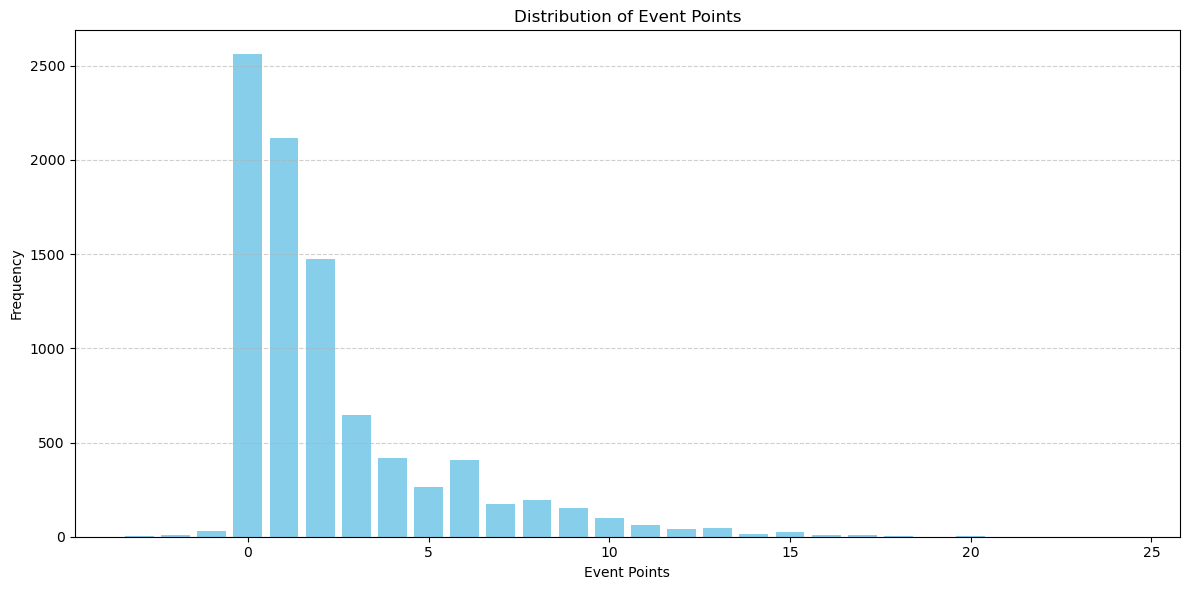

In [29]:
# Plot the distribution of 'event_points' as a bar graph using matplotlib
import matplotlib.pyplot as plt

# Count the frequency of each unique event_points value
points_counts = data[(data['minutes'] >= 60)]['event_points'].value_counts().sort_index()

# Create the bar plot
plt.figure(figsize=(12, 6))
plt.bar(points_counts.index, points_counts.values, color='skyblue')
plt.xlabel('Event Points')
plt.ylabel('Frequency')
plt.title('Distribution of Event Points')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


What I want to look at first is player-specific traits rather than match-specific.

In other words, what past information will actually help decision-making based on future information?

1. What players are the 'streakiest'?


In [6]:
playersG = datai[datai["points_per_game"]>3.5]
gw = datai["gw"].max()
playersG = playersG[playersG["gw"]==gw]
playersG = playersG[playersG["minutes"]>=600]
playersG = playersG["first_name"] + playersG["second_name"]
datai["name"] = datai["first_name"] + datai["second_name"]


/var/folders/3g/nvkhhf6x0kd5ct41682nlpr00000gn/T/ipykernel_1586/4036659892.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datai["name"] = datai["first_name"] + datai["second_name"]


In [9]:
corr_list = []
for player in playersG:
    df_player = datai[datai["name"] == player]
    if len(df_player) > 1:
        corr = df_player["form"].corr(df_player["event_points"])
    else:
        corr = None
    corr_list.append({"name": player, "corr_form_points": corr})

players_now = pd.DataFrame(corr_list)

print(players_now.sort_values(by="corr_form_points", ascending=False, na_position="last").head(10))
print(players_now.sort_values(by="corr_form_points", ascending=True, na_position="last").head(10))

                                                  name  corr_form_points
40                                        FlorianWirtz          0.738204
64                                             OlaAina          0.731364
1                                         IlimanNdiaye          0.728796
16                                         MatsWieffer          0.715370
8                                           JoshCullen          0.706134
108                                     TinoLivramento          0.674459
9                                   MarcosSenesi Barón          0.664807
0                                        RyanSessegnon          0.662036
80   João MariaLobo Alves Palhares Costa Palhinha G...          0.660513
106                                Jean-PhilippeMateta          0.646436
                                name  corr_form_points
69                     DanielBallard         -0.001021
55             BrunoBorges Fernandes          0.210151
59    BrunoGuimarães Rodriguez M

By the eye test, this shows some good results. Let's try again, using a boolean 'return' (4+ points that week) to check, and also comparing that to last week's 'return' to see how things look.

In [11]:
corr_list = []
datai['return'] = datai['event_points']>=4
datai = datai.sort_values(["name", "gw"])
datai['returnLast'] = datai['event_points'].shift(1)>=4
 
datai.loc[datai['gw'] == 1, 'return'] = False

for player in playersG:
    df_player = datai[datai["name"] == player]
    if len(df_player) > 1:
        corr = df_player["form"].corr(df_player["return"])
        corr2 = df_player["returnLast"].corr(df_player["return"])

    else:
        corr = None
    corr_list.append({"name": player, "corr_form_return": corr, "corr_lastReturn_return": corr2})

players_now = pd.DataFrame(corr_list)

print(players_now.sort_values(by="corr_lastReturn_return", ascending=False, na_position="last").head(10))
print(players_now.sort_values(by="corr_lastReturn_return", ascending=True, na_position="last").head(10))

                            name  corr_form_return  corr_lastReturn_return
108               TinoLivramento          0.904445                0.887151
92                   JamesGarner          0.585156                0.469231
16                   MatsWieffer          0.547583                0.467801
45                   HugoEkitiké          0.588353                0.467801
64                       OlaAina          0.660863                0.452381
37          DominicCalvert-Lewin          0.525117                0.425000
90                   IsmaïlaSarr          0.518372                0.394737
109  Gabrieldos Santos Magalhães          0.679094                0.393939
23             DanielMuñoz Mejía          0.441199                0.375046
49                   RayanCherki          0.688358                0.375046
                        name  corr_form_return  corr_lastReturn_return
103  EmilianoMartínez Romero          0.433351               -0.352941
106      Jean-PhilippeMateta     

I like this new correlation parameter, as it's a lot more clear-cut (binary form in both present and last week, rather than influenced by past point outliers). Let's use both of these moving forward, but keep sorting by the two-week form correlation.

Now, let's also look at past years for more substantive sample data.

I can see that in the past year databases, names are not added, so let's join those extra databases in.

In [14]:
data = pd.read_csv('playerstats2425.csv', low_memory = False)
data2 = pd.read_csv('players2425.csv', low_memory = False)
datafull = pd.merge(data, data2, left_on="id", right_on="player_id", how="left")

datafull['return'] = datafull['event_points']>=4
datafull["name"] = datafull["first_name"] + datafull["second_name"]
datafull = datafull.sort_values(["name", "gw"])
datafull['returnLast'] = datafull['event_points'].shift(1)>=4

playersG = datafull[datafull["points_per_game"]>3]
playersG = playersG[playersG["gw"]==38]
playersG = playersG[playersG["total_points"]>=75]
playersG = playersG["first_name"] + playersG["second_name"]

corr_list = []
for player in playersG:
    df_player = datafull[datafull["name"] == player]
    if len(df_player) > 1:
        corr = df_player["form"].corr(df_player["return"])
        corr2 = df_player["returnLast"].corr(df_player["return"])

    else:
        corr = None
    corr_list.append({"name": player, "corr_form_return": corr, "corr_lastReturn_return": corr2})

players_then = pd.DataFrame(corr_list)

print(players_then.sort_values(by="corr_lastReturn_return", ascending=False, na_position="last").head(10))
print(players_then.sort_values(by="corr_lastReturn_return", ascending=True, na_position="last").head(10))


                name  corr_form_return  corr_lastReturn_return
102        PhilFoden          0.640618                0.474654
17        BukayoSaka          0.646606                0.409190
47      HarveyBarnes          0.470010                0.360269
11       AshleyYoung          0.608890                0.345441
45   GeorginioRutter          0.640986                0.314815
46       HarryWilson          0.583937                0.299539
8      AnthonyElanga          0.515496                0.298462
39     EnzoFernández          0.562988                0.298462
79    MartinØdegaard          0.538017                0.277417
9      AnthonyGordon          0.621726                0.269231
                 name  corr_form_return  corr_lastReturn_return
28      DeanHenderson          0.195782               -0.403077
27   DavidRaya Martin          0.534568               -0.357143
62      JoškoGvardiol          0.410332               -0.323573
94      NathanCollins          0.403485            

2) Now, let's try out a random forest model to pick match winners based off of team matchup, home/away, and past performance. I'll use SphinxAPI to help me download all gameweek data in a more efficient and organized way, and for help with developing the model.

In [3]:
dataPS = pd.read_csv('playerstats.csv', low_memory = False)
dataPlayers = pd.read_csv('players.csv', low_memory = False)
dataTeams = pd.read_csv('teams.csv', low_memory = False)



In [16]:
# Download fixtures.csv for all gameweeks 1-38
import os

def download_all_gw_fixtures(base_url, save_dir, max_gw=38):
    os.makedirs(save_dir, exist_ok=True)
    for gw in range(1, max_gw+1):
        url = base_url.format(gw=gw)
        save_path = os.path.join(save_dir, f'fixtures{gw}.csv')
        try:
            download_file_from_github(url, save_path)
        except Exception as e:
            print(f"Error downloading GW{gw}: {e}")

# Example usage:
base_url = "https://raw.githubusercontent.com/olbauday/FPL-Core-Insights/main/data/2025-2026/By%20Gameweek/GW{gw}/fixtures.csv"
save_dir = "/Users/alex/Documents/FPL Project/fixtures/"
download_all_gw_fixtures(base_url, save_dir)

File downloaded successfully to /Users/alex/Documents/FPL Project/fixtures/fixtures1.csv
File downloaded successfully to /Users/alex/Documents/FPL Project/fixtures/fixtures2.csv
File downloaded successfully to /Users/alex/Documents/FPL Project/fixtures/fixtures3.csv
File downloaded successfully to /Users/alex/Documents/FPL Project/fixtures/fixtures4.csv
File downloaded successfully to /Users/alex/Documents/FPL Project/fixtures/fixtures5.csv
File downloaded successfully to /Users/alex/Documents/FPL Project/fixtures/fixtures6.csv
File downloaded successfully to /Users/alex/Documents/FPL Project/fixtures/fixtures7.csv
File downloaded successfully to /Users/alex/Documents/FPL Project/fixtures/fixtures8.csv
File downloaded successfully to /Users/alex/Documents/FPL Project/fixtures/fixtures9.csv
File downloaded successfully to /Users/alex/Documents/FPL Project/fixtures/fixtures10.csv
File downloaded successfully to /Users/alex/Documents/FPL Project/fixtures/fixtures11.csv
File downloaded suc

In [40]:
# Merge all fixture CSVs into a comprehensive table
import glob

# Path for all fixtures
fixture_files = sorted(glob.glob('fixtures/fixtures*.csv'))

# Read all fixtures and concatenate, keeping all columns
fixture_dfs = [pd.read_csv(f) for f in fixture_files]
fixture_merged = pd.concat(fixture_dfs, axis=0, ignore_index=True, sort=False)

# Move key columns to the front for interpretability
key_cols = [
    col for col in [
        'gameweek', 
        'home_team', 'home_team_elo', 'home_score', 
        'away_team', 'away_team_elo', 'away_score',
        'kickoff_time', 'finished', 'tournament',
    ] if col in fixture_merged.columns
]
other_cols = [c for c in fixture_merged.columns if c not in key_cols]
fixture_merged = fixture_merged[key_cols + other_cols]


# Merge fixture_merged with dataTeams to get home and away team names
fixture_named = fixture_merged.copy()

# Map codes to team names for home and away teams
code_to_name = dict(zip(dataTeams['code'], dataTeams['name']))
fixture_named['home_team'] = fixture_named['home_team'].map(code_to_name)
fixture_named['away_team'] = fixture_named['away_team'].map(code_to_name)
fixture_named = fixture_named[fixture_named['match_id'].str.startswith('25-26-prem')]



# Display first few rows to verify
print(fixture_named[['gameweek', 'home_team', 'home_score', 'away_team', 'away_score']].head())
display(fixture_named.head())

   gameweek      home_team  home_score    away_team  away_score
0       1.0         Wolves         0.0     Man City         4.0
1       1.0  Nott'm Forest         3.0    Brentford         1.0
2       1.0      Liverpool         4.0  Bournemouth         2.0
3       1.0    Aston Villa         0.0    Newcastle         0.0
4       1.0       Brighton         1.0       Fulham         1.0


,gameweek,home_team,home_team_elo,home_score,away_team,away_team_elo,away_score,kickoff_time,finished,tournament,...,home_walking_distance,away_walking_distance,home_running_distance,away_running_distance,home_sprinting_distance,away_sprinting_distance,home_number_of_sprints,away_number_of_sprints,home_top_speed,away_top_speed
0,1.0,Wolves,1735.78,0.0,Man City,1959.96,4.0,2026-01-24T15:00:00,True,prem,...,34111.0,34774.0,73109.0,81836.0,2386.0,2514.0,116.0,130.0,33.200001,33.900002
1,1.0,Nott'm Forest,1802.85,3.0,Brentford,1811.30,1.0,2026-01-25T14:00:00,True,prem,...,36591.0,34043.0,68316.0,75124.0,1932.0,1816.0,100.0,95.0,32.599998,35.000000
2,1.0,Liverpool,1993.42,4.0,Bournemouth,1808.10,2.0,2026-01-24T17:30:00,True,prem,...,35425.0,33096.0,73524.0,75328.0,3609.0,3830.0,161.0,174.0,36.099998,33.799999
3,1.0,Aston Villa,1872.85,0.0,Newcastle,1868.57,0.0,2026-01-25T14:00:00,True,prem,...,33303.0,33858.0,70707.0,73917.0,1904.0,2711.0,93.0,132.0,33.700001,35.500000
4,1.0,Brighton,1827.14,1.0,Fulham,1781.73,1.0,2026-01-24T15:00:00,True,prem,...,33872.0,34845.0,76199.0,72455.0,2260.0,1916.0,108.0,94.0,32.900002,33.500000


Let's see how the model does with predicting GW23 (the most recent gameweek) based off of prior weeks.

In [53]:
# Add gameweek, home_team, and away_team as model features (categorical encoding for teams)
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Select features for modeling
categorical_features = ['home_team', 'away_team']
numeric_features = ['home_team_elo', 'away_team_elo', 'gameweek']

# Use fixture_named, filter as before
train_gws = list(range(1, 23))
test_gw = 23

# Prepare train/test splits
train_df = fixture_named[fixture_named['gameweek'].isin(train_gws)]
test_df = fixture_named[fixture_named['gameweek'] == test_gw]

feature_cols = numeric_features + categorical_features

# Separate X/y for home and away models
X_train = train_df[feature_cols]
X_test = test_df[feature_cols]
y_train_home = train_df['home_score']
y_train_away = train_df['away_score']
y_test_home = test_df['home_score']
y_test_away = test_df['away_score']

# Set up column transformer for encoding
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('num', 'passthrough', numeric_features)
])

# Instantiate and fit pipelines for home and away predictions
home_pipe = Pipeline([
    ('pre', preprocessor),
    ('reg', RandomForestRegressor(n_estimators=100, random_state=42))
])
away_pipe = Pipeline([
    ('pre', preprocessor),
    ('reg', RandomForestRegressor(n_estimators=100, random_state=42))
])

home_pipe.fit(X_train, y_train_home)
away_pipe.fit(X_train, y_train_away)

y_pred_home = home_pipe.predict(X_test)
y_pred_away = away_pipe.predict(X_test)

# Compile results
results_cat = pd.DataFrame({
    'gameweek': test_gw,
    'home_team': test_df['home_team'].values,
    'pred_home_score': y_pred_home.round(2),
    'true_home_score': y_test_home.values,
    'away_team': test_df['away_team'].values,
    'pred_away_score': y_pred_away.round(2),
    'true_away_score': y_test_away.values
})

print(results_cat)
print("\nMean Squared Error (home goals):", mean_squared_error(y_test_home, y_pred_home))
print("Mean Squared Error (away goals):", mean_squared_error(y_test_away, y_pred_away))
# Optional: Show feature importances (categorical may expand to many columns)
try:
    feature_names = (
        list(home_pipe.named_steps['pre'].transformers_[0][1].get_feature_names_out(categorical_features)) +
        numeric_features
    )
    home_importances = home_pipe.named_steps['reg'].feature_importances_
    sorted_idx = np.argsort(home_importances)[::-1]
    print("\nTop 10 home RF feature importances:")
    for idx in sorted_idx[:10]:
        print(f"{feature_names[idx]}: {home_importances[idx]:.4f}")
except Exception as e:
    print("(Feature importances not available or error)")


   gameweek       home_team  pred_home_score  true_home_score      away_team  \
0        23     Bournemouth             1.27              3.0      Liverpool   
1        23       Brentford             1.99              0.0  Nott'm Forest   
2        23        West Ham             1.63              3.0     Sunderland   
3        23         Burnley             1.31              2.0          Spurs   
4        23          Fulham             1.48              2.0       Brighton   
5        23  Crystal Palace             0.63              1.0        Chelsea   
6        23         Everton             1.79              1.0          Leeds   
7        23        Man City             2.37              2.0         Wolves   
8        23       Newcastle             1.60              0.0    Aston Villa   
9        23         Arsenal             1.77              2.0        Man Utd   

   pred_away_score  true_away_score  
0             0.88              2.0  
1             0.88              2.0  
2    

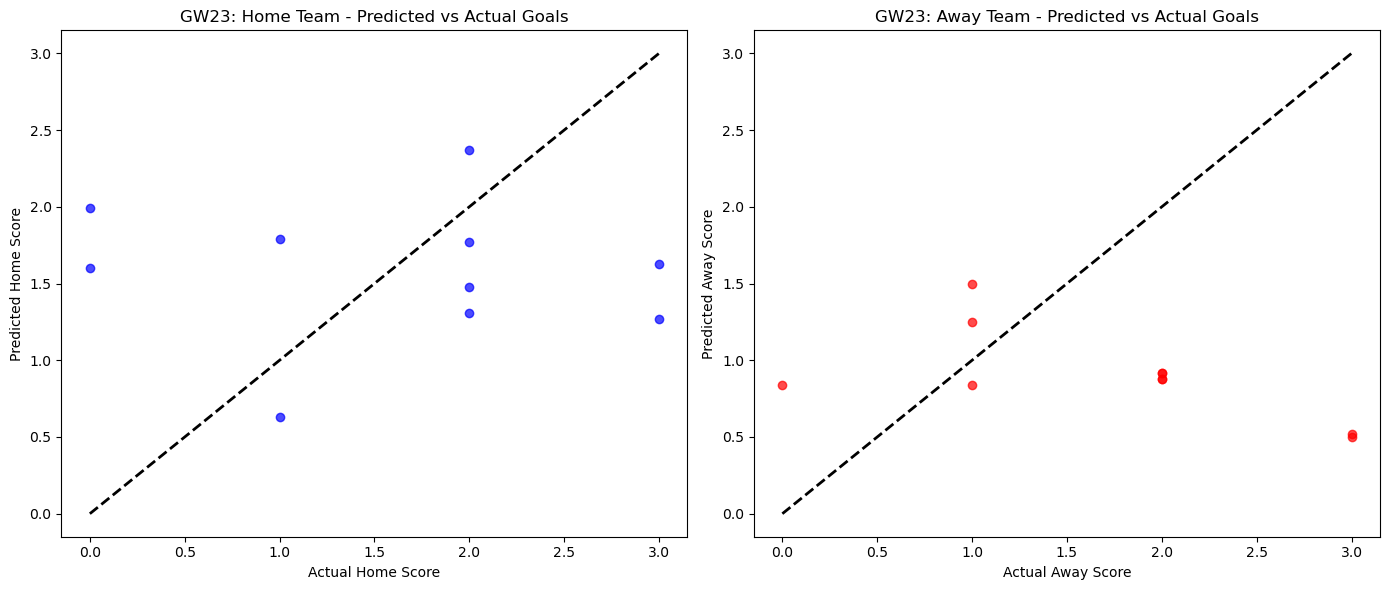

Largest home prediction errors (categorical features):
     home_team  pred_home_score  true_home_score  home_error_signed
1    Brentford             1.99              0.0               1.99
0  Bournemouth             1.27              3.0              -1.73
8    Newcastle             1.60              0.0               1.60
2     West Ham             1.63              3.0              -1.37
6      Everton             1.79              1.0               0.79

Largest away prediction errors (categorical features):
       away_team  pred_away_score  true_away_score  away_error_signed
5        Chelsea             0.50              3.0              -2.50
9        Man Utd             0.52              3.0              -2.48
0      Liverpool             0.88              2.0              -1.12
1  Nott'm Forest             0.88              2.0              -1.12
3          Spurs             0.92              2.0              -1.08


In [56]:
# Plot predicted vs actual for GW23 home and away scores for interpretability (with categorical features)
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(results_cat['true_home_score'], results_cat['pred_home_score'], c='blue', alpha=0.7)
axes[0].plot([results_cat['true_home_score'].min(), results_cat['true_home_score'].max()],
             [results_cat['true_home_score'].min(), results_cat['true_home_score'].max()], 'k--', lw=2)
axes[0].set_xlabel('Actual Home Score')
axes[0].set_ylabel('Predicted Home Score')
axes[0].set_title('GW23: Home Team - Predicted vs Actual Goals')

axes[1].scatter(results_cat['true_away_score'], results_cat['pred_away_score'], c='red', alpha=0.7)
axes[1].plot([results_cat['true_away_score'].min(), results_cat['true_away_score'].max()],
             [results_cat['true_away_score'].min(), results_cat['true_away_score'].max()], 'k--', lw=2)
axes[1].set_xlabel('Actual Away Score')
axes[1].set_ylabel('Predicted Away Score')
axes[1].set_title('GW23: Away Team - Predicted vs Actual Goals')

plt.tight_layout()
plt.show()


results_cat['home_error_signed'] = results_cat['pred_home_score'] - results_cat['true_home_score']
results_cat['away_error_signed'] = results_cat['pred_away_score'] - results_cat['true_away_score']

# Calculate absolute errors for sorting
results_cat['home_error_abs'] = results_cat['home_error_signed'].abs()
results_cat['away_error_abs'] = results_cat['away_error_signed'].abs()

print('Largest home prediction errors (categorical features):')
# Sort FIRST on the full dataframe, THEN select columns
print(results_cat.sort_values('home_error_abs', ascending=False)[['home_team', 'pred_home_score', 'true_home_score', 'home_error_signed']].head(5))

print('\nLargest away prediction errors (categorical features):')
print(results_cat.sort_values('away_error_abs', ascending=False)[['away_team', 'pred_away_score', 'true_away_score', 'away_error_signed']].head(5))

Clearly a less predictable week - let's see if the model's performance has improved over time or remains affected by noise. We'll use Sphinx to develop a rolling forward validation model that should better estimate time series data.

RMSE trend: slope = 0.002 (change per gameweek)


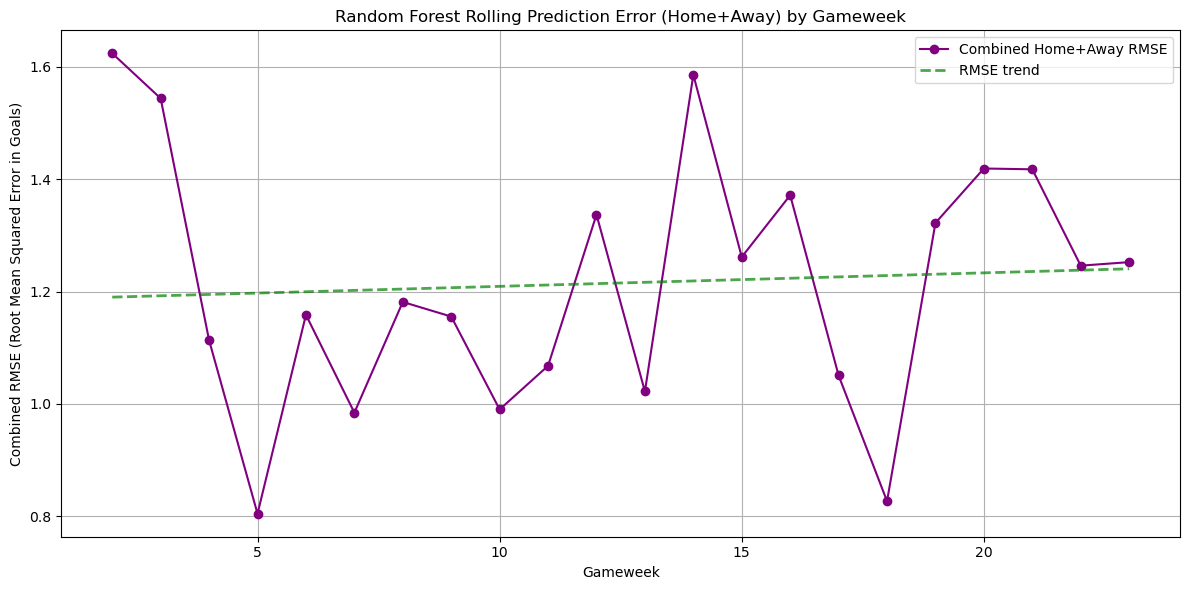

RMSE slope: 0.0024


In [103]:
# Rolling forward validation for RF: predict each week using all prior weeks, plot error by week
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt

# Columns to use -- categorical and numeric (as previously discussed)
categorical_features = ['home_team', 'away_team']
numeric_features = ['home_team_elo', 'away_team_elo', 'gameweek']
feature_cols = numeric_features + categorical_features

gws = sorted(fixture_named['gameweek'].dropna().unique())

mse_home = []
mse_away = []
gw_used = []

for gw in gws[1:]:  # start at GW2
    train = fixture_named[(fixture_named['gameweek'] < gw) & fixture_named['gameweek'].notnull()]
    test = fixture_named[fixture_named['gameweek'] == gw]
    
    # Prepare X/y and skip GWs with invalid data
    X_train = train[feature_cols]
    X_test = test[feature_cols]
    y_train_home = train['home_score']
    y_test_home = test['home_score']
    y_train_away = train['away_score']
    y_test_away = test['away_score']
    
    # Only keep complete data (no NaNs in features/targets)
    train_valid = (~X_train.isnull().any(axis=1)) & (~y_train_home.isnull()) & (~y_train_away.isnull())
    test_valid = (~X_test.isnull().any(axis=1)) & (~y_test_home.isnull()) & (~y_test_away.isnull())
    
    if train_valid.sum() == 0 or test_valid.sum() == 0:
        continue  # Skip this GW
    X_train = X_train.loc[train_valid]
    y_train_home = y_train_home.loc[train_valid]
    y_train_away = y_train_away.loc[train_valid]
    X_test = X_test.loc[test_valid]
    y_test_home = y_test_home.loc[test_valid]
    y_test_away = y_test_away.loc[test_valid]
    
    preprocessor = ColumnTransformer([
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', 'passthrough', numeric_features)
    ])

    rf_home = Pipeline([
        ('pre', preprocessor),
        ('reg', RandomForestRegressor(n_estimators=100, random_state=42))
    ])
    rf_away = Pipeline([
        ('pre', preprocessor),
        ('reg', RandomForestRegressor(n_estimators=100, random_state=42))
    ])
    rf_home.fit(X_train, y_train_home)
    rf_away.fit(X_train, y_train_away)
    
    y_pred_home = rf_home.predict(X_test)
    y_pred_away = rf_away.predict(X_test)
    
    mse_home.append(mean_squared_error(y_test_home, y_pred_home))
    mse_away.append(mean_squared_error(y_test_away, y_pred_away))
    gw_used.append(gw)

# Compute combined RMSE (sum or mean) per gameweek
combined_rmse = np.sqrt((np.array(mse_home) + np.array(mse_away)) / 2)

plt.figure(figsize=(12,6))
plt.plot(gw_used, combined_rmse, label='Combined Home+Away RMSE', marker='o', color='purple')
z_rmse = np.polyfit(gw_used, combined_rmse, 1)
p_rmse = np.poly1d(z_rmse)
plt.plot(gw_used, p_rmse(gw_used), "--", color='green', alpha=0.7, linewidth=2, label='RMSE trend')
# Print the trend
print(f"RMSE trend: slope = {z_rmse[0]:.3f} (change per gameweek)")
plt.xlabel('Gameweek')
plt.ylabel('Combined RMSE (Root Mean Squared Error in Goals)')
plt.title('Random Forest Rolling Prediction Error (Home+Away) by Gameweek')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"RMSE slope: {z_rmse[0]:.4f}")

Clearly, the model only slightly improves each week, which may make sense based off of the very limited data available (and can be largely attributed to chance).

Let's compare this RF model with my personal predictions, which imperfectly take into account injuries, team news, tournament games (team fatigue), and the 'eye test'.

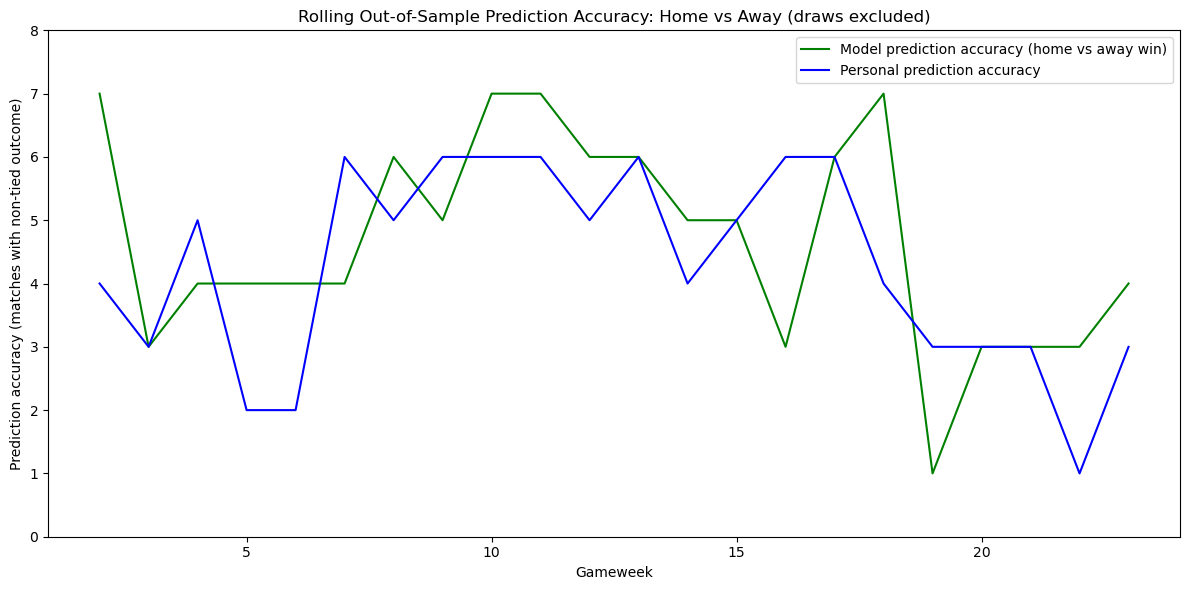

In [106]:
pred_win_acc = []
gw_used = []
pred_win_total = []

for gw in gws[1:]:  # start at GW2
    train = fixture_named[(fixture_named['gameweek'] < gw) & fixture_named['gameweek'].notnull()]
    test = fixture_named[fixture_named['gameweek'] == gw]

    X_train = train[feature_cols]
    X_test = test[feature_cols]
    y_train_home = train['home_score']
    y_test_home = test['home_score']
    y_train_away = train['away_score']
    y_test_away = test['away_score']

    train_valid = (~X_train.isnull().any(axis=1)) & (~y_train_home.isnull()) & (~y_train_away.isnull())
    test_valid = (~X_test.isnull().any(axis=1)) & (~y_test_home.isnull()) & (~y_test_away.isnull())

    if train_valid.sum() == 0 or test_valid.sum() == 0:
        continue
    X_train = X_train.loc[train_valid]
    y_train_home = y_train_home.loc[train_valid]
    y_train_away = y_train_away.loc[train_valid]
    X_test = X_test.loc[test_valid]
    y_test_home = y_test_home.loc[test_valid]
    y_test_away = y_test_away.loc[test_valid]

    preprocessor = ColumnTransformer([
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', 'passthrough', numeric_features)
    ])

    rf_home = Pipeline([
        ('pre', preprocessor),
        ('reg', RandomForestRegressor(n_estimators=100, random_state=42))
    ])
    rf_away = Pipeline([
        ('pre', preprocessor),
        ('reg', RandomForestRegressor(n_estimators=100, random_state=42))
    ])
    rf_home.fit(X_train, y_train_home)
    rf_away.fit(X_train, y_train_away)

    y_pred_home = rf_home.predict(X_test)
    y_pred_away = rf_away.predict(X_test)

    # Determine only matches with non-tied true outcomes
    mask = y_test_home != y_test_away
    if mask.sum() == 0:
        continue
    # For win-draw-loss: 1=home win, 0=away win
    true_win = (y_test_home > y_test_away)[mask]
    pred_win = (y_pred_home > y_pred_away)[mask]
    acc = (true_win == pred_win).sum()
    pred_win_acc.append(acc)
    gw_used.append(gw)
    total = mask.sum()
    pred_win_total.append(total)

plt.figure(figsize=(12,6))

# First line - your existing model predictions
plt.plot(gw_used, pred_win_acc, color='green', label='Model prediction accuracy (home vs away win)')

# Second line - personal predictions from CSV
personalPreds = pd.read_csv('Fantasy PL Stats(Teams).csv', low_memory=False)
personalPreds = personalPreds[personalPreds["GW"]>1]
summary = personalPreds.groupby('GW')['Correct pred?'].value_counts().unstack(fill_value=0)

# Calculate accuracy: TRUE / (TRUE + FALSE)
personal_accuracy = summary[True] 

# Plot personal predictions
plt.plot(personal_accuracy.index, personal_accuracy.values, color='blue', label='Personal prediction accuracy')

# Formatting
plt.xlabel('Gameweek')
plt.ylabel('Prediction accuracy (matches with non-tied outcome)')
plt.title('Rolling Out-of-Sample Prediction Accuracy: Home vs Away (draws excluded)')
plt.ylim(0, 8)
plt.legend()
plt.tight_layout()
plt.show()



In [111]:
print("Model accuracy:", sum(pred_win_acc)/sum(pred_win_total))
print("Personal accuracy:", sum(personal_accuracy.values)/sum(pred_win_total))
print("Model improvement:", 100*(sum(pred_win_acc)/sum(personal_accuracy.values)-1), "%")


Model accuracy: 0.6358024691358025
Personal accuracy: 0.5802469135802469
Model improvement: 9.57446808510638 %


On a last note, my personal (tieless) predictions usually aim for a 2-1 scoreline, as that's my assumption of the most likely outcome (regardless of matchup). Let's see how accurate this is to reality:

In [113]:
print(fixture_named["home_score"].mean())
print(fixture_named["away_score"].mean())

1.5521739130434782
1.2043478260869565
